In [1]:
"""
The objective here is to predict sleep apnea from time series signals
The dataset used is from the ENS Dreem Data challenge 2021:
https://challengedata.ens.fr/participants/challenges/45/
"""

'\nThe objective here is to predict sleep apnea from time series signals\nThe dataset used is from the ENS Dreem Data challenge 2021:\nhttps://challengedata.ens.fr/participants/challenges/45/\n'

In [2]:
"""
Cheating: Codex was not able to find every necessary library after writing all the code, therefore I import the libraries myself here
"""
# Importing libraries
import h5py
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Input, Flatten, Dropout, Reshape, ReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from keras import backend as K

In [3]:
"""
Cheating: I was not able to load the dataset properly using Codex only, therefore I do it myself here
"""
# The amount of rows of data to collect
n_data = 4400

# Loading data
PATH_TO_TRAINING_DATA = "/kaggle/input/dreem-dataset/X_train.h5"
PATH_TO_TRAINING_TARGET = "/kaggle/input/dreem-dataset/y_train.csv"
file = h5py.File(PATH_TO_TRAINING_DATA, 'r')
data = file['data']

# Preprocessing data
N_signals = 8
x = data[:n_data, 2:]
x = x.reshape(n_data, N_signals, -1)
x = np.transpose(x, (0, 2, 1))
y = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))[
    :n_data, 1:]

"""
x is a 3D array with shape (n_data, 9000, 8)
- n_data is the number of rows of data
- 9000 is the number of data points per row, 90 seconds divided into 100 points
- 8 is the number of signals measured

y is a 2D array with shape (n_data, 90)
- n_data is the number of rows of data
- 90 is the amount of predictions, one per second, 1 if sleep apnea, 0 otherwise
"""

'\nx is a 3D array with shape (n_data, 9000, 8)\n- n_data is the number of rows of data\n- 9000 is the number of data points per row, 90 seconds divided into 100 points\n- 8 is the number of signals measured\n\ny is a 2D array with shape (n_data, 90)\n- n_data is the number of rows of data\n- 90 is the amount of predictions, one per second, 1 if sleep apnea, 0 otherwise\n'

In [4]:
# Normalize x
# Normalize each signal
for i in range(N_signals):
    x[:, :, i] = (x[:, :, i] - np.mean(x[:, :, i])) / np.std(x[:, :, i])

In [5]:
# For each value of y, copy it 100 times along the second axis
"""
Slight cheating: Codex stored the new array in y, since I need y for later, I replaced every y with y_temp
"""
y_temp = np.repeat(y, 100, axis=1)

In [6]:
# Find every index where y = 1
index_1 = np.where(y_temp == 1)[0]

In [7]:
# Pick a random index from index_1
index_1 = np.random.choice(index_1)

In [8]:
# Do a train test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

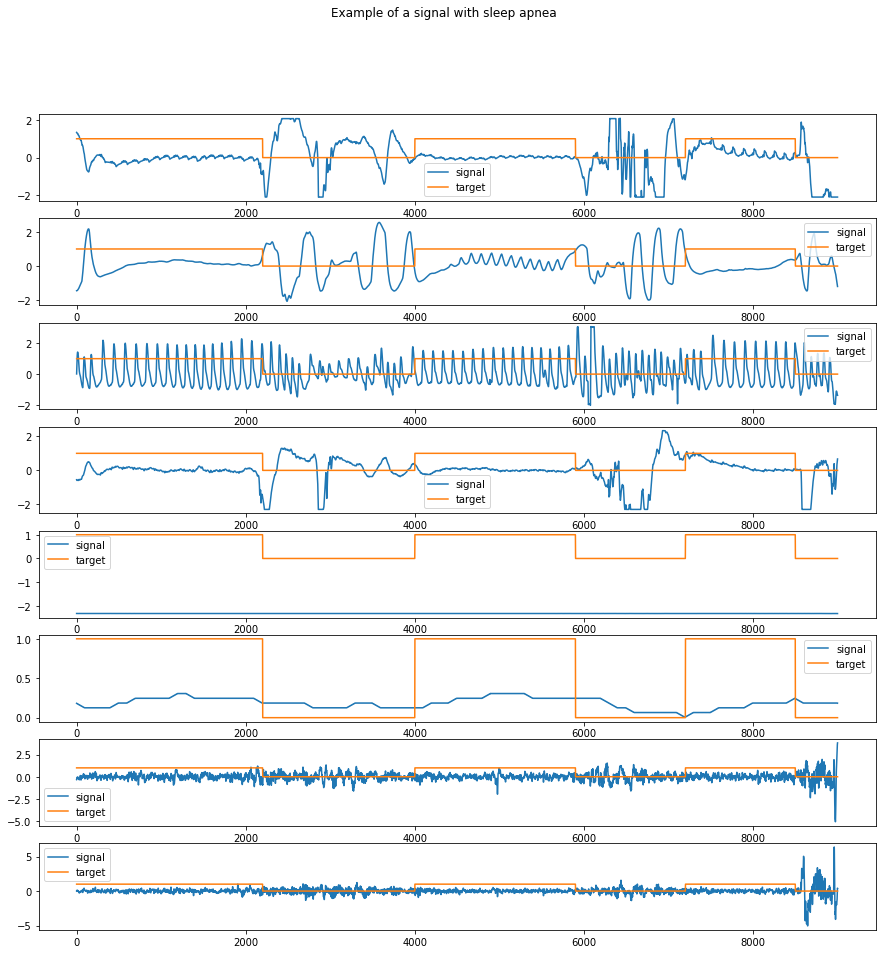

In [9]:
# Plot the corresponding x and y examples, one plot per signal
fig, ax = plt.subplots(nrows=N_signals, ncols=1, figsize=(15, 15))
for i in range(N_signals):
    ax[i].plot(x[index_1, :, i], label='signal')
    ax[i].plot(y_temp[index_1, :], label='target')
    ax[i].legend()

# Give the plot a title
plt.suptitle('Example of a signal with sleep apnea')
plt.show()

In [10]:
"""
Cheating: Codex did not find a functionning model for this problem, I code the model here myself
"""
# Creating a model
X_input_true = Input([9000, N_signals])

X_true = Conv1D(filters=20, kernel_size=20, padding='same')(X_input_true)
X_true = MaxPool1D(10)(X_true)
X_true = ReLU()(X_true)
X_true = Dropout(0.2)(X_true)
X_true = Conv1D(filters=40, kernel_size=20, padding='same')(X_true)
X_true = MaxPool1D(10)(X_true)
X_true = ReLU()(X_true)
X_true = Dropout(0.2)(X_true)

z = Conv1D(filters=40, kernel_size=20, padding='same')(X_true)
z = ReLU()(z)
z = Dropout(0.2)(z)
z = Conv1D(filters=1, kernel_size=10, padding='same',
           activation='sigmoid')(z)

model = Model(inputs=X_input_true, outputs=z)

In [11]:
# Create a F1 score metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[f1])


In [13]:
# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32,
          validation_data=(x_test, y_test),
          callbacks=[
              EarlyStopping(monitor='val_loss', patience=10),
              ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1),
              ModelCheckpoint(filepath='model.h5', monitor='val_loss',
                              save_best_only=True)
          ])

Epoch 1/100
110/110 [==============================] - 10s 24ms/step - loss: 0.2776 - f1: 0.0040 - val_loss: 0.2087 - val_f1: 0.0073
Epoch 2/100
110/110 [==============================] - 2s 14ms/step - loss: 0.2193 - f1: 0.0294 - val_loss: 0.1781 - val_f1: 0.2232
Epoch 3/100
110/110 [==============================] - 2s 16ms/step - loss: 0.1873 - f1: 0.2390 - val_loss: 0.1898 - val_f1: 0.4419
Epoch 4/100
110/110 [==============================] - 2s 14ms/step - loss: 0.1724 - f1: 0.3379 - val_loss: 0.1589 - val_f1: 0.4215
Epoch 5/100
110/110 [==============================] - 1s 14ms/step - loss: 0.1649 - f1: 0.3835 - val_loss: 0.1568 - val_f1: 0.4534
Epoch 6/100
110/110 [==============================] - 1s 13ms/step - loss: 0.1615 - f1: 0.4087 - val_loss: 0.1704 - val_f1: 0.5456
Epoch 7/100
110/110 [==============================] - 2s 14ms/step - loss: 0.1583 - f1: 0.4359 - val_loss: 0.1758 - val_f1: 0.5455
Epoch 8/100
110/110 [==============================] - 2s 15ms/step - loss:

In [14]:
# Load the best model
model.load_weights('model.h5')

In [15]:
# Evaluate the model
model.evaluate(x_test, y_test)

28/28 [==============================] - 0s 8ms/step - loss: 0.1311 - f1: 0.6057


[0.13114650547504425, 0.6056585311889648]